## Zadanie 1 - Dla obrazu monochromatycznego:
1. Obliczyć entropię obrazu wejściowego.
1. Wyznaczyć obraz różnicowy w taki sposób, że wartość każdego piksela zastępowana jest różnicą
pomiędzy wartością tego piksela a wartością jego lewego sąsiada (kodowanie różnicowe /.
predykcyjne). Dla pierwszego piksela w linii należy przyjąć wartość sąsiada równą 127 (środkowa
wartość przedziału zmienności wartości pikseli).\
Wyświetlić obraz różnicowy.\
Wyznaczyć histogram obrazu różnicowego i porównać go z histogramem obrazu oryginalnego.\
Wyznaczyć entropię obrazu różnicowego i porównać ją z entropią obrazu oryginalnego.\
Uwaga: należy pamiętać, że wartości pikseli w obrazie różnicowym są z zakresu [-255; 255]!
1. Wyznaczyć współczynniki DWT korzystając z funkcji zamieszczonej w przykładowym skrypcie.\
Wyświetlić poszczególne pasma.\
Wyznaczyć histogramy i obliczyć entropię dla wszystkich pasm.\
Porównać wyniki (histogram, entropia) uzyskane dla poszczególnych pasm między sobą (czy któreś
się wyróżniają i dlaczego?) oraz z wynikami uzyskanymi dla obrazu oryginalnego i obrazu
różnicowego.
Uwaga: należy pamiętać, że wartości w pasmach LH, HL i HH są z zakresu [-255, 255]!\
1. Obliczyć przepływność (liczbę bitów przypadającą na jeden piksel) dla obrazu skompresowanego
koderem PNG (obraz wejściowy) i porównać ją z obliczonymi uprzednio entropiami obrazu
oryginalnego, różnicowego i falokowego.\
Czy przepływność mniejsza od entropii oznacza, że
zależność: lśr ≥ H jest nieprawdziwa?


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

os.makedirs("results1", exist_ok=True)
os.makedirs("results2", exist_ok=True)

image = cv2.imread("images/sailboats_mono.png", cv2.IMREAD_UNCHANGED)

def printi(img, img_title="image"):
    print(f"{img_title}, wymiary: {img.shape}, typ danych: {img.dtype}, wartości: {img.min()} - {img.max()}")


def cv_imshow(img, img_title="image"):
    if (img.dtype == np.float32) or (img.dtype == np.float64):
        img_ = img / 255
    elif img.dtype == np.int16:
        img_ = img*128
    else:
        img_ = img
    cv2.imshow(img_title, img_)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

### 1. Obliczanie entropii

In [ ]:
def calc_entropy(hist):
    pdf = hist/hist.sum() # Histogram normalized to probability density function (PDF)
    entropy = -sum([x*np.log2(x) for x in pdf if x != 0])
    return entropy

hist_image = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()

H_image = calc_entropy(hist_image)
print(f"H(image) = {H_image:.4f}")

H(image) = 7.0567


### 2.1. Wyznaczyć obraz różnicowy

In [ ]:
img_tmp1 = image[:, 1:]
img_tmp2 = image[:, :-1]

image_hdiff = cv2.addWeighted(img_tmp1, 1, img_tmp2, -1, 0, dtype=cv2.CV_16S)

# Add first column
image_hdiff_0 = cv2.addWeighted(image[:, 0], 1, 0, 0, -127, dtype=cv2.CV_16S)
image_hdiff = np.hstack((image_hdiff_0, image_hdiff))

### 2.2. Wyświetlić obraz różnicowy

In [99]:
cv_imshow(image_hdiff, "image_hdiff")
image_scaled = (np.clip((image_hdiff + 255), 0, 510) * 0.5).astype(np.uint8)
cv2.imwrite("results1/image_hdiff.png", image_scaled)

True

### 2.3 Histogram różnicowy i oryginalny

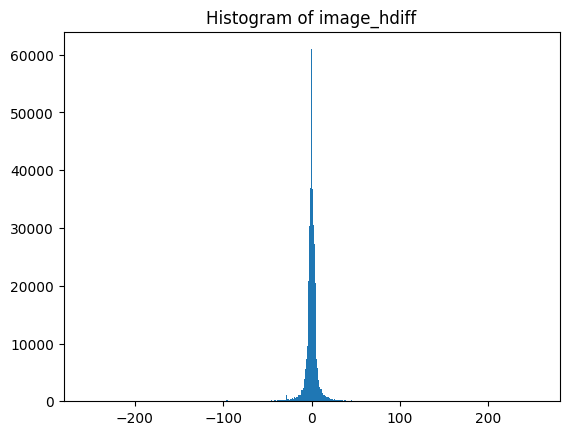

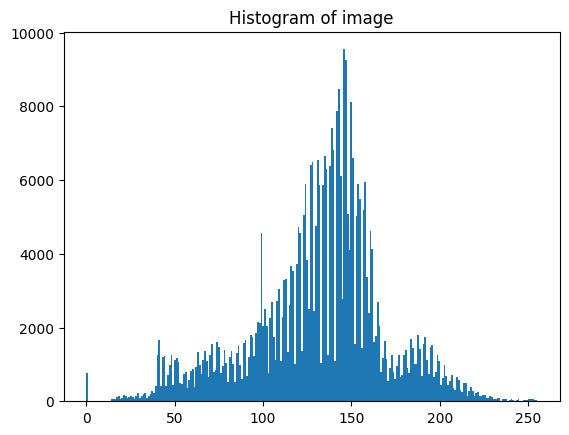

In [94]:
plt.figure()
plt.hist(image_hdiff.flatten(), 511, range=[-255.0, 255.0])
plt.title("Histogram of image_hdiff")
plt.show()

plt.figure()
plt.hist(image.flatten(), 256, range=[0.0, 255.0])
plt.title("Histogram of image")
plt.show()

Obraz różnicowy przedstawia różnicę wartości piksela względem jego sąsiada.\
Histogram różnicowy względem oryginalnego:\
Ma 2-razy większy zakres wartości [-255, 255]\
Wartości są bardziej skoncentrowane i zbliżone do zera.\

### 2.4. Entropia obrazu różnicowego i oryginalnego

In [ ]:
# Calculate entropy of image_hdiff
image_tmp = (image_hdiff+255).astype(np.uint16)
hist_hdiff = cv2.calcHist([image_tmp], [0], None, [511], [0, 511]).flatten()

H_hdiff = calc_entropy(hist_hdiff)
print(f"H(hdiff) = {H_hdiff:.4f}")
print(f"H(image) = {H_image:.4f}")

H(hdiff) = 4.5567
H(image) = 7.0567


Entropia obrazu różnicowego jest mniejsza od obrazu oryginalnego, gdyż histogram obrazu różnicowanego jest bardziej skoncentrowany.

### 3.1-2. Wyznaczyć współczynniki DWT oraz wyświetlenie poszczególnych pasm

In [57]:
def dwt(img):
    """
    Bardzo prosta i podstawowa implementacja, nie uwzględniająca efektywnych metod obliczania DWT
    i dopuszczająca pewne niedokładności.
    """
    maskL = np.array([0.02674875741080976, -0.01686411844287795, -0.07822326652898785, 0.2668641184428723,
        0.6029490182363579, 0.2668641184428723, -0.07822326652898785, -0.01686411844287795, 0.02674875741080976])
    maskH = np.array([0.09127176311424948, -0.05754352622849957, -0.5912717631142470, 1.115087052456994,
        -0.5912717631142470, -0.05754352622849957, 0.09127176311424948])

    bandLL = cv2.sepFilter2D(img,         -1, maskL, maskL)[::2, ::2]
    bandLH = cv2.sepFilter2D(img, cv2.CV_16S, maskL, maskH)[::2, ::2] ### ze względu na filtrację górnoprzepustową -> wartości ujemne, dlatego wynik 16-bitowy ze znakiem
    bandHL = cv2.sepFilter2D(img, cv2.CV_16S, maskH, maskL)[::2, ::2]
    bandHH = cv2.sepFilter2D(img, cv2.CV_16S, maskH, maskH)[::2, ::2]

    return bandLL, bandLH, bandHL, bandHH

In [97]:
# DWT coefficients
ll, lh, hl, hh = dwt(image)
printi(ll, "LL")
printi(lh, "LH")
printi(hl, "HL")
printi(hh, "HH")

cv_imshow(ll, "LL2")
cv_imshow(cv2.multiply(lh, 2), "LH2")
cv_imshow(cv2.multiply(hl, 2), "HL2")
cv_imshow(cv2.multiply(hh, 2), "HH2")

cv2.imwrite("results2/ll.png", ll)
lh_scaled = np.clip(lh + 128, 0, 255)
cv2.imwrite("results2/lh.png", lh_scaled)
hl_scaled = np.clip(hl + 128, 0, 255)
cv2.imwrite("results2/hl.png", hl_scaled)
hh_scaled = np.clip(hh + 128, 0, 255)
cv2.imwrite("results2/hh.png", hh_scaled)

LL, wymiary: (384, 256), typ danych: uint8, wartości: 9 - 255
LH, wymiary: (384, 256), typ danych: int16, wartości: -97 - 125
HL, wymiary: (384, 256), typ danych: int16, wartości: -116 - 164
HH, wymiary: (384, 256), typ danych: int16, wartości: -110 - 152


True

### 3.3 Wyznaczyć histogramy oraz entropie dla wszystkich pasm

H(LL) = 7.1395 
H(LH) = 4.1734 
H(HL) = 4.0514 
H(HH) = 4.2601 
H_śr = 4.9061


(-255.0, 255.0)

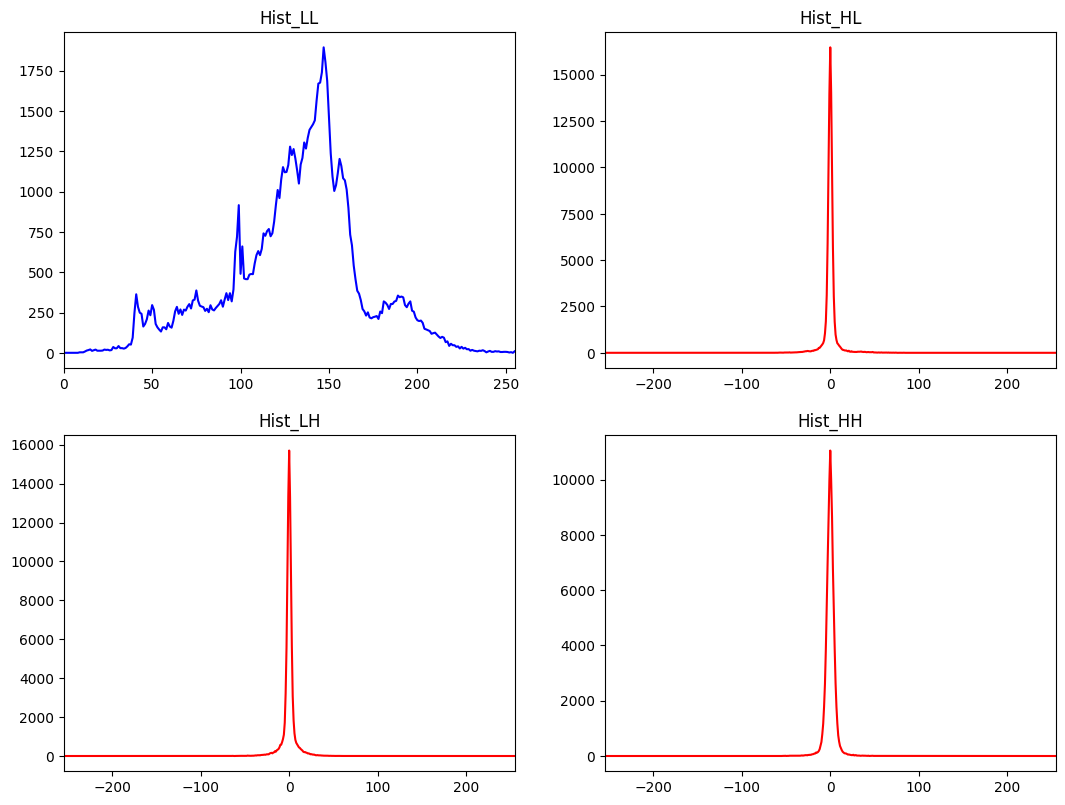

In [100]:
hist_ll = cv2.calcHist([ll], [0], None, [256], [0, 256]).flatten()
hist_lh = cv2.calcHist([(lh + 255).astype(np.uint16)], [0], None, [511], [0, 511]).flatten()
hist_hl = cv2.calcHist([(hl + 255).astype(np.uint16)], [0], None, [511], [0, 511]).flatten()
hist_hh = cv2.calcHist([(hh + 255).astype(np.uint16)], [0], None, [511], [0, 511]).flatten()

H_ll = calc_entropy(hist_ll)
H_lh = calc_entropy(hist_lh)
H_hl = calc_entropy(hist_hl)
H_hh = calc_entropy(hist_hh)
print(f"H(LL) = {H_ll:.4f} \nH(LH) = {H_lh:.4f} \nH(HL) = {H_hl:.4f} \nH(HH) = {H_hh:.4f} \nH_śr = {(H_ll+H_lh+H_hl+H_hh)/4:.4f}")


fig = plt.figure()
fig.set_figheight(fig.get_figheight()*2)
fig.set_figwidth(fig.get_figwidth()*2)
plt.subplot(2, 2, 1)
plt.plot(hist_ll, color="blue")
plt.title("Hist_LL")
plt.xlim([0, 255])
plt.subplot(2, 2, 3)
plt.plot(np.arange(-255, 256, 1), hist_lh, color="red")
plt.title("Hist_LH")
plt.xlim([-255, 255])
plt.subplot(2, 2, 2)
plt.plot(np.arange(-255, 256, 1), hist_hl, color="red")
plt.title("Hist_HL")
plt.xlim([-255, 255])
plt.subplot(2, 2, 4)
plt.plot(np.arange(-255, 256, 1), hist_hh, color="red")
plt.title("Hist_HH")
plt.xlim([-255, 255])

### 3.4. Porównanie wyników

Pasma o wyższej częstotliwości HL, LH, HH mają mniejszą entropię niż pasmo niskich częstotliwości LL.\
Histogramy HL, LH, HH są bardziej skoncetrowane w pobliżu 0.\
Entropia oraz histogramy pasm HL, LH, HH są podobne do obrazu różnicowego. Natomiast pasmo LL do oryginalnego. Spowodowane jest to tym, że pasmo LL skupia się na głównych kształtach tak jak obraz oryginalny, a pozostałe pasma to szczegóły tak jak jest to w przyapdku obrazu różnicowego.

### 4.1. Obliczyć przepływność dla obrazu skompresowanego koderem PNG

In [ ]:
bitrate = 8 * os.stat("images/sailboats_mono.png").st_size / (image.shape[0] * image.shape[1])
print(f"bitrate: {bitrate:.4f}")

bitrate: 4.6111


Bitreate jest mniejszy od entropii obrazu oryginalnego ale podobny do entropii obrazu różnicowego.\
W odniesieniu do entropii pasm falkowych jest on mniejszy od średniej entropii ale wyższy od entropii pasm wysokoczęstotliwościowych.\
Wniosek:\
Oznacza to, że algorytm PNG skutecznie wykorzystał zależności lokalne pomiędzy pikselami, osiągając niemal optymalną kompresję względem modelu różnicowego. Tym samym kompresja bezstratna zbliżyła się do teoretycznego limitu wynikającego z entropii różnicowej.\

Czy przepływność mniejsza od entropii oznacza, że zależność: lśr ≥ H jest nieprawdziwa?/
Entropia obliczonego obrazu dotyczy pojedynczych pikseli. Ignoruje zależnośći przestrzenne. Zakłada, że piksele są niezależne.\
Natomiast PNG to kompresja z predykcją. Uwzględnia zależności.\
Naszą zależność powinniśmy porównać do innego źródłą. Do entropii obrazu różnicowego. Dla tego źródła zależność jest spełniona:\
lśr ≥ H(hdiff)\
4.6111 ≥ 4.5567
